In [16]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import utils as utils
# Set my plot theme
# See here for more detials
# https://github.com/RishiSadhir/rethinking2/blob/master/utils/plotting.py
utils.set_theme()
COLOR = "#2A0933"

In [17]:
%load_ext jupyterstan

# Medium
## 4H1

In [11]:
d = utils.data_from_R("Howell1", "rethinking")
d.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [31]:
%%stan m_4h1
data {
  int N;
  vector[N] height;
  vector[N] weight;
}
parameters {
  real alpha;
  real<lower=0> beta1;
  real beta2;
  real<lower=0> sigma;
}
model {
  vector[N] mu;

  alpha ~ normal(178, 20);
  beta1 ~ lognormal(0, 1);
  beta2 ~ normal(0, 1);
  
  mu = alpha + beta1*weight + beta2*square(weight);
  height ~ normal(mu, sigma);
}

INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_4h1_1536069c7a8e54ebe3e4ce66a535ed77 NOW.


Creating pystan model & assigning it to variable name "m_4h1".
Stan options:
 {'model_name': 'm_4h1', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "m_4h1"!
Compilation took 35 seconds.


In [38]:
d_dict = {
    "N": len(d.index),
    "weight": d["weight"].tolist(),
    "height": d["height"].tolist()
}
fit = m_4h1.sampling(d_dict)
fit

Inference for Stan model: m_4h1_1536069c7a8e54ebe3e4ce66a535ed77.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  46.13    0.04   1.21   43.8  45.31  46.15  46.97  48.47   1146   1.01
beta1   4.19  2.5e-3   0.09   4.02   4.13   4.19   4.25   4.35   1132    1.0
beta2  -0.04  3.8e-5 1.3e-3  -0.04  -0.04  -0.04  -0.04  -0.04   1217    1.0
sigma   5.78  4.6e-3   0.18   5.44   5.66   5.78    5.9   6.14   1583    1.0
lp__   -1246    0.04   1.48  -1250  -1247  -1246  -1245  -1244   1187    1.0

Samples were drawn using NUTS at Sat Apr  4 16:34:57 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [93]:
post = fit.extract()
weight = [46.95, 43.72, 64.78, 32.59, 54.63]
m = np.array([np.ones(shape=5), np.array(weight), np.square(weight)])
post_mu = np.matmul(np.transpose(m), p)

pd.DataFrame({
    "Individual": [1,2,3,4,5],
    "Weight": weight,
    "Expected Height": [np.round(np.mean(i)) for i in post_mu],
    "89% Interval": [np.round(utils.hpdi(i, .11),2) for i in post_mu]})

,Individual,Weight,Expected Height,89% Interval
0,1,46.95,158.0,"[157.64, 158.64]"
1,2,43.72,156.0,"[155.35, 156.32]"
2,3,64.78,156.0,"[154.29, 158.35]"
3,4,32.59,142.0,"[141.28, 142.55]"
4,5,54.63,160.0,"[159.48, 161.31]"


# 4H2

In [100]:
d = utils.data_from_R("Howell1", "rethinking")
d = d[d['age']<18]
d.describe()

,height,weight,age,male
count,192.000000,192.000000,192.000000,192.000000
mean,108.318853,18.414193,7.721875,0.479167
std,25.745139,8.939313,5.366235,0.500872
min,53.975000,4.252425,0.000000,0.000000
25%,89.128600,11.708343,3.000000,0.000000
50%,111.125000,16.981350,7.000000,0.000000
75%,127.723900,23.416687,12.000000,1.000000
max,158.115000,44.735511,17.000000,1.000000


In [148]:
%%stan m_4h2_1
data {
  int N;
  vector[N] height;
  vector[N] weight;
  int prior_only;
}
parameters {
  real alpha;
  real<lower=0> beta1;
  real<lower=0> sigma;
}
model {
  alpha ~ normal(100, 30);
  beta1 ~ lognormal(0, 1);
  sigma ~ exponential(1);
  
  if (!prior_only) {
    height ~ normal(alpha + beta1*weight, sigma);
  }
}


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_4h2_1_09fd8472cba3b9c965f76cba89c431e6 NOW.


Creating pystan model & assigning it to variable name "m_4h2_1".
Stan options:
 {'model_name': 'm_4h2_1', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "m_4h2_1"!
Compilation took 35 seconds.


In [208]:
def center(x):
    return x - np.mean(x)
def scale(x):
    return x / np.std(x)
def standardize(x):
    return scale(center(x))

In [209]:
d_dict = {
    "N": len(d.index),
    "height": d['height'].tolist(),
    "weight": center(d['weight']),
    "prior_only": 0}
fit = m_4h2_1.sampling(d_dict, chains = 4, n_jobs = 4)
print(fit.stansummary(probs = [.05, .95]))

Inference for Stan model: m_4h2_1_09fd8472cba3b9c965f76cba89c431e6.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd     5%    95%  n_eff   Rhat
alpha  108.3    0.01    0.6 107.28 109.28   3435    1.0
beta1   2.72  1.2e-3   0.07    2.6   2.83   3349    1.0
sigma   8.35  6.6e-3   0.41   7.72   9.05   3784    1.0
lp__  -513.7    0.03   1.23 -516.1 -512.4   2013    1.0

Samples were drawn using NUTS at Sat Apr  4 19:08:23 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


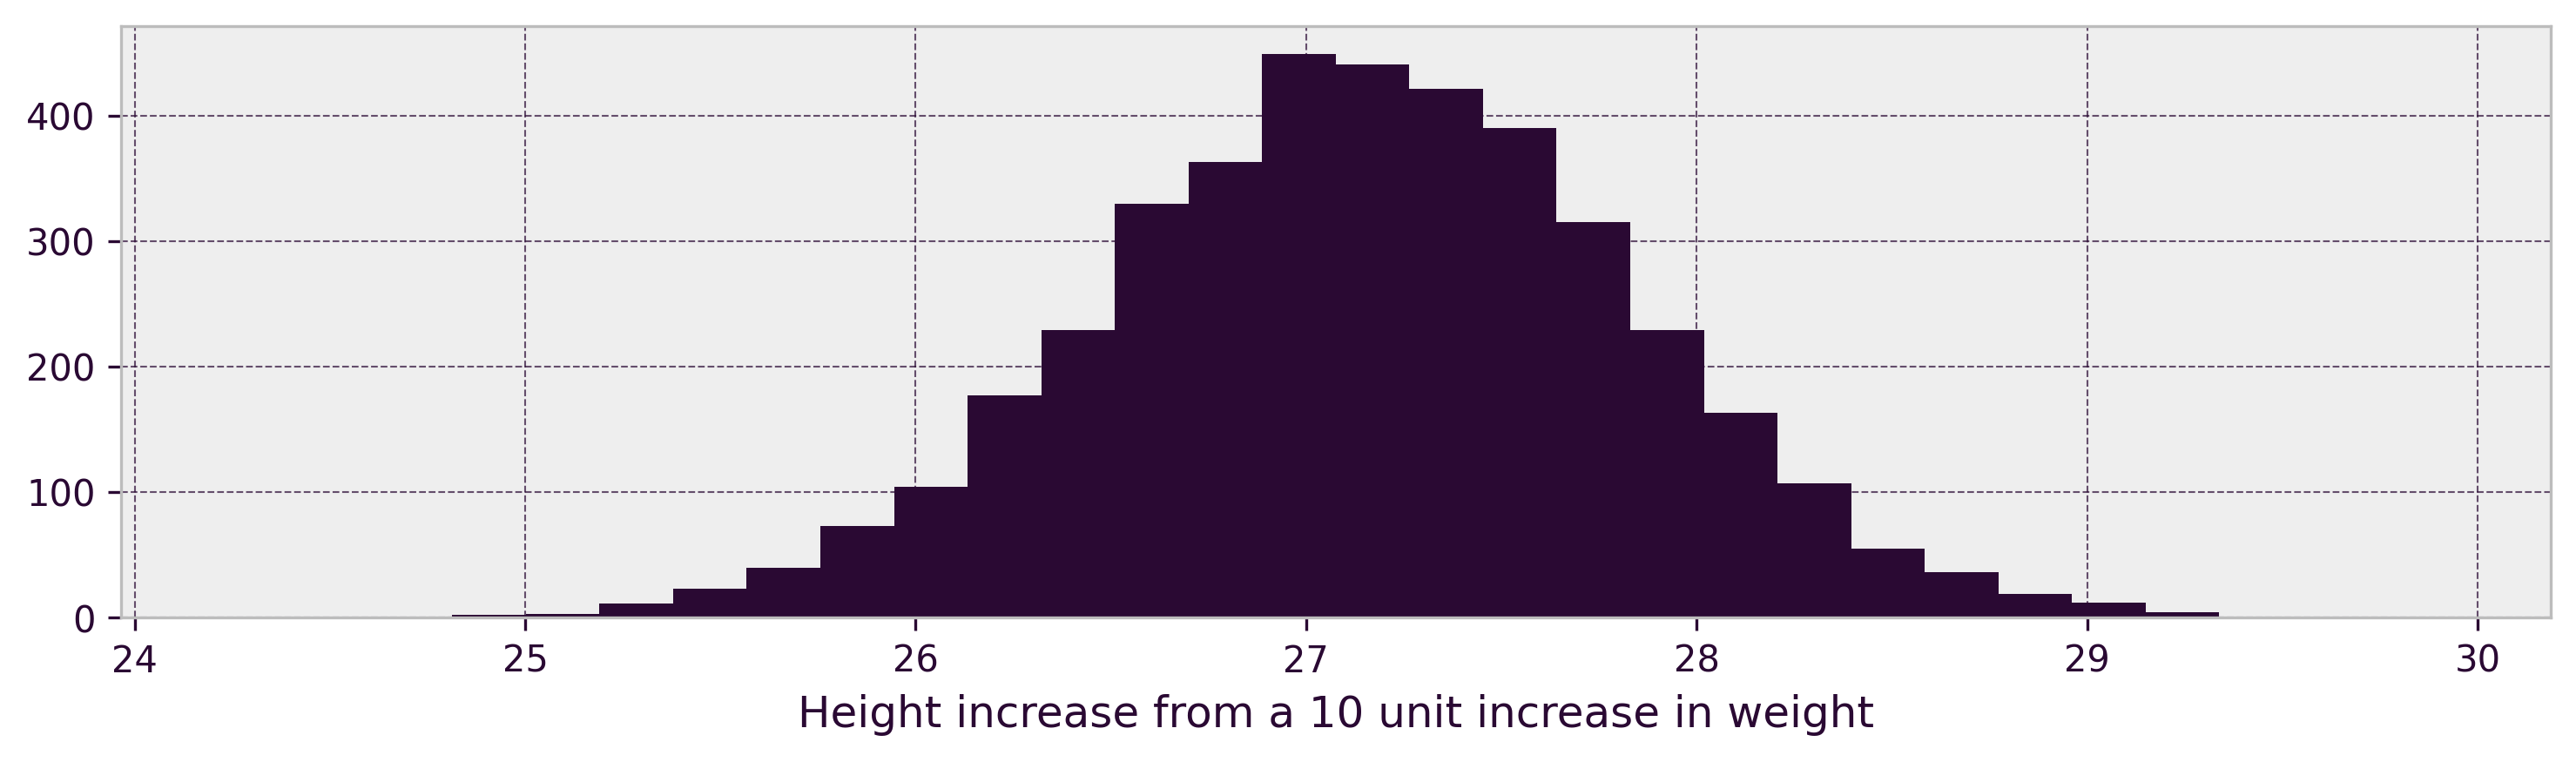

In [210]:
post = fit.extract()
fig, axes = plt.subplots(figsize = (12,3))
axes.hist(post["beta1"] * 10, bins = 30, color = COLOR)
axes.set_xlabel("Height increase from a 10 unit increase in weight")
plt.show()

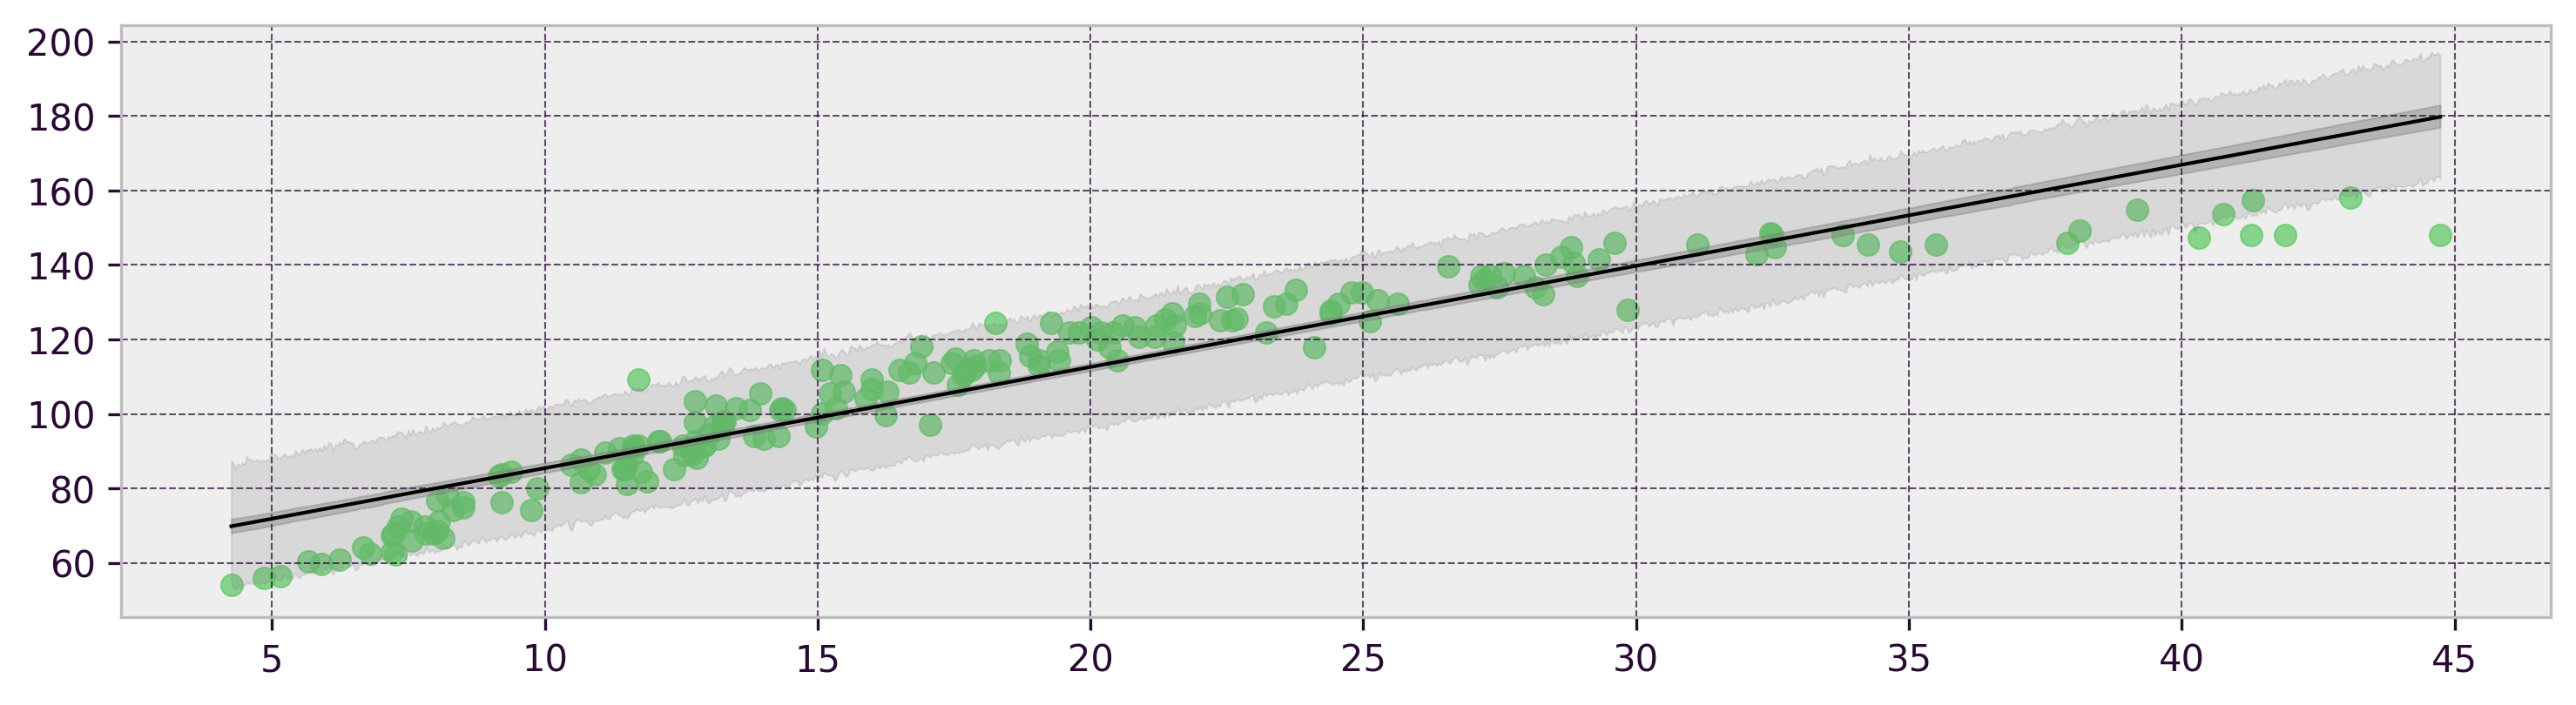

In [248]:
xseq = np.linspace(min(d['weight']), max(d['weight']), 1000)
X = np.array([[1]*1000, xseq-np.mean(d['weight'])])
B = np.array([post['alpha'], post['beta1']])
Y = np.matmul(np.transpose(X), B)
Y_shade = np.array([utils.hpdi(y, .11) for y in Y])

def sim(w):
    m = post['alpha'] + post['beta1'] * (w - np.mean(d['weight']))
    r = stats.norm.rvs(m, post['sigma'], len(m))
    return r
pred = np.array([sim(w) for w in wseq])
pred_shade = np.array([utils.hpdi(p) for p in pred])

fig, ax = plt.subplots(figsize = (12,3))
ax.scatter(d["weight"], d["height"], 
           color = "#5CC863", alpha = .7)
ax.fill_between(xseq, Y_shade[:,0], Y_shade[:,1], 
                     color="grey", alpha = .4)
ax.fill_between(xseq, pred_shade[:,0], pred_shade[:,1], 
                     color="grey", alpha = .2)
ax.plot(xseq, np.array([np.mean(y) for y in Y]), 
        color = "black", linewidth = 1)
plt.show()

# 4H3

In [260]:
d = utils.data_from_R("Howell1", "rethinking")
d.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


In [257]:
%%stan m_4h3_1
data {
  int N;
  vector[N] height;
  vector[N] weight;
  int prior_only;
}
parameters {
  real alpha;
  real<lower=0> beta1;
  real<lower=0> sigma;
}
model {
  alpha ~ normal(100, 30);
  beta1 ~ normal(0, 1);
  sigma ~ exponential(1);
  
  if (!prior_only) {
    height ~ normal(alpha + beta1*log(weight), sigma);
  }
}


INFO:pystan:COMPILING THE C++ CODE FOR MODEL m_4h3_1_1aa450eb41807f718e1262442a44b282 NOW.


Creating pystan model & assigning it to variable name "m_4h3_1".
Stan options:
 {'model_name': 'm_4h3_1', 'include_paths': None, 'boost_lib': None, 'eigen_lib': None, 'verbose': False, 'obfuscate_model_name': True}
StanModel now available as variable "m_4h3_1"!
Compilation took 37 seconds.


In [261]:
d_dict = {
    "N": len(d.index),
    "height": d['height'].tolist(),
    "weight": d['weight'],
    "prior_only": 0}
fit = m_4h3_1.sampling(d_dict, chains = 4, n_jobs = 4)
print(fit.stansummary(probs = [.05, .95]))

Inference for Stan model: m_4h3_1_1aa450eb41807f718e1262442a44b282.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

        mean se_mean     sd     5%    95%  n_eff   Rhat
alpha   79.7    0.16   4.79  71.58  87.53    867    1.0
beta1  17.02    0.05   1.37  14.78  19.33    870    1.0
sigma  17.82    0.03   0.91  16.35  19.35    956    1.0
lp__   -2004    0.04   1.23  -2007  -2003   1202    1.0

Samples were drawn using NUTS at Sat Apr  4 19:48:18 2020.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


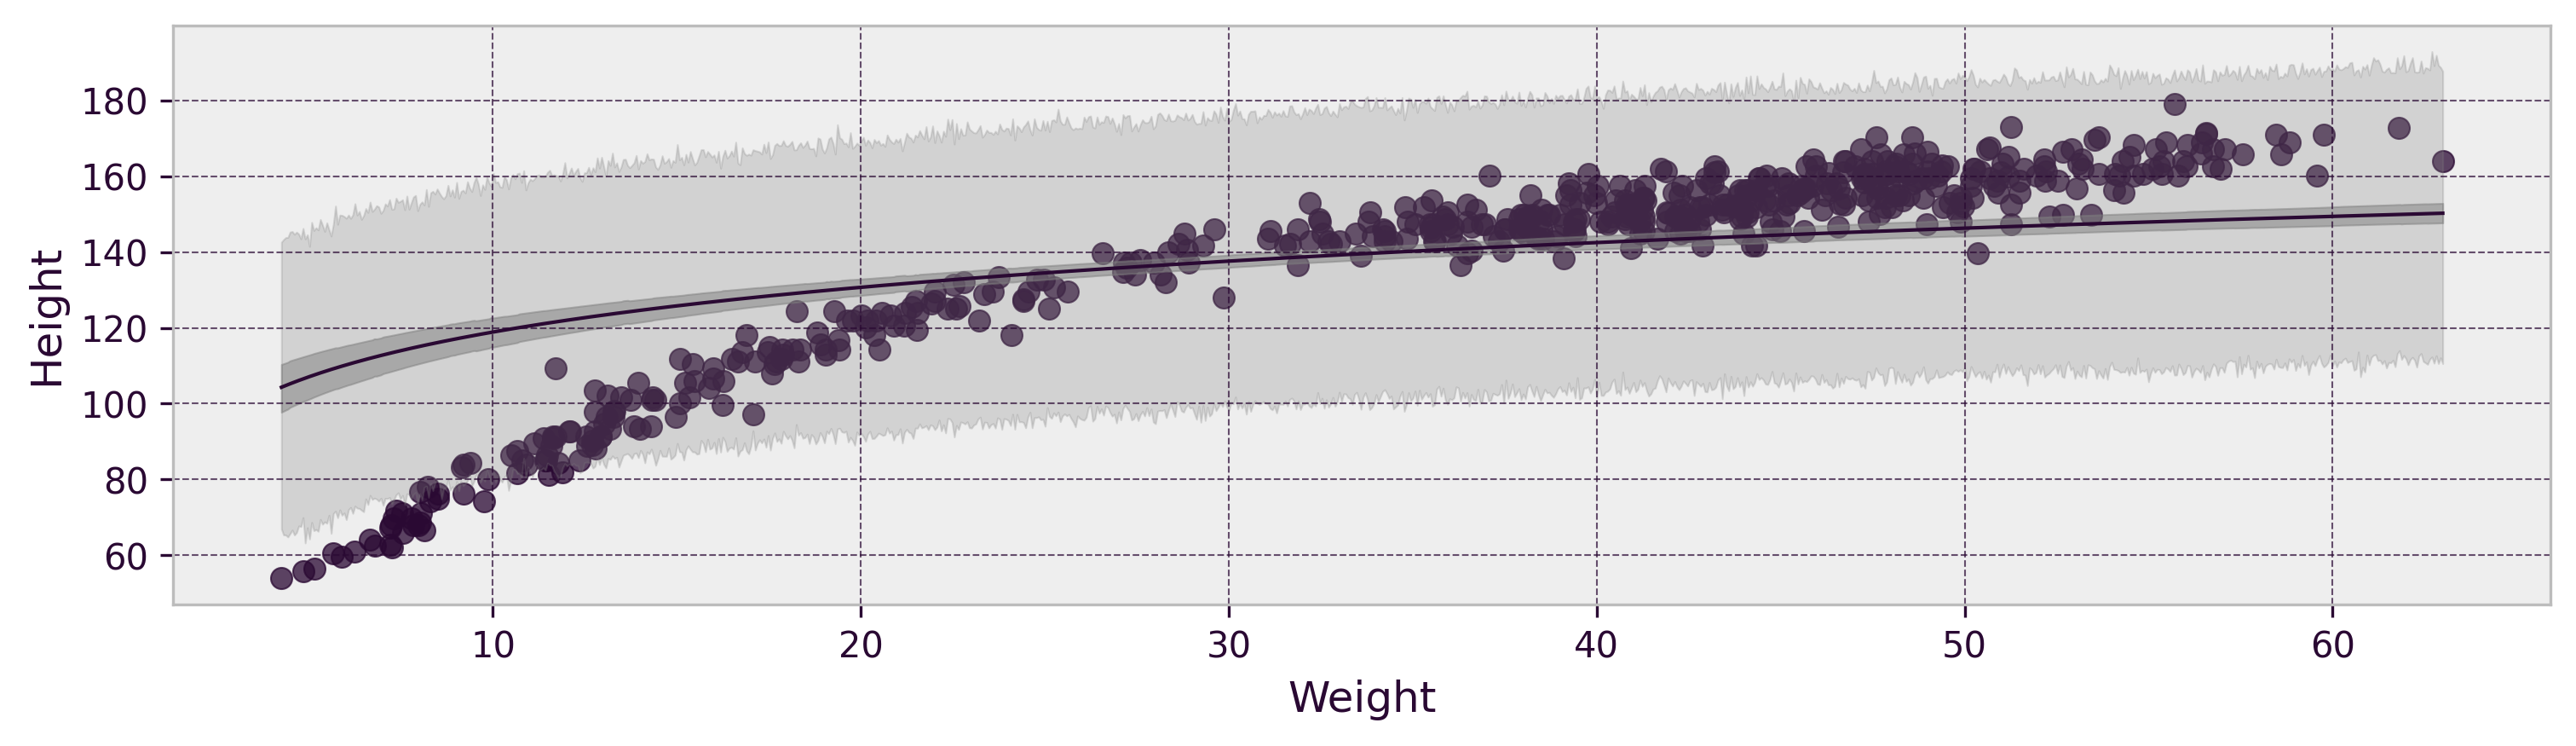

In [335]:
xseq = np.linspace(min(d['weight']), max(d['weight']), 1000)
post = fit.extract()
X = np.array([[1]*1000, np.log(xseq)])
B = np.array([post['alpha'], post['beta1']])
MU = np.matmul(np.transpose(X), B)
MU_shade = np.array([utils.hpdi(y, .03) for y in MU])
Preds = np.array([stats.norm.rvs(m, post['sigma'], len(m)) for m in MU])
Preds_shade = np.array([utils.hpdi(y, .03) for y in Preds])

fig, ax = plt.subplots(figsize=(12, 3))
ax.scatter(d['weight'], d['height'], color = COLOR, alpha = .75)
ax.plot(xseq, np.array([np.mean(y) for y in MU]), color = COLOR, linewidth=1)
ax.fill_between(xseq, MU_shade[:,0], MU_shade[:,1], 
                     color="grey", alpha = .5)
ax.fill_between(xseq, Preds_shade[:,0], Preds_shade[:,1], 
                     color="grey", alpha = .25)
ax.set_xlabel("Weight")
ax.set_ylabel("Height")
plt.show()

# 4H4

In [430]:
d = utils.data_from_R("Howell1", "rethinking")
d.describe()

,height,weight,age,male
count,544.000000,544.000000,544.000000,544.000000
mean,138.263596,35.610618,29.344393,0.472426
std,27.602448,14.719178,20.746888,0.499699
min,53.975000,4.252425,0.000000,0.000000
25%,125.095000,22.007717,12.000000,0.000000
50%,148.590000,40.057844,27.000000,0.000000
75%,157.480000,47.209005,43.000000,1.000000
max,179.070000,62.992589,88.000000,1.000000


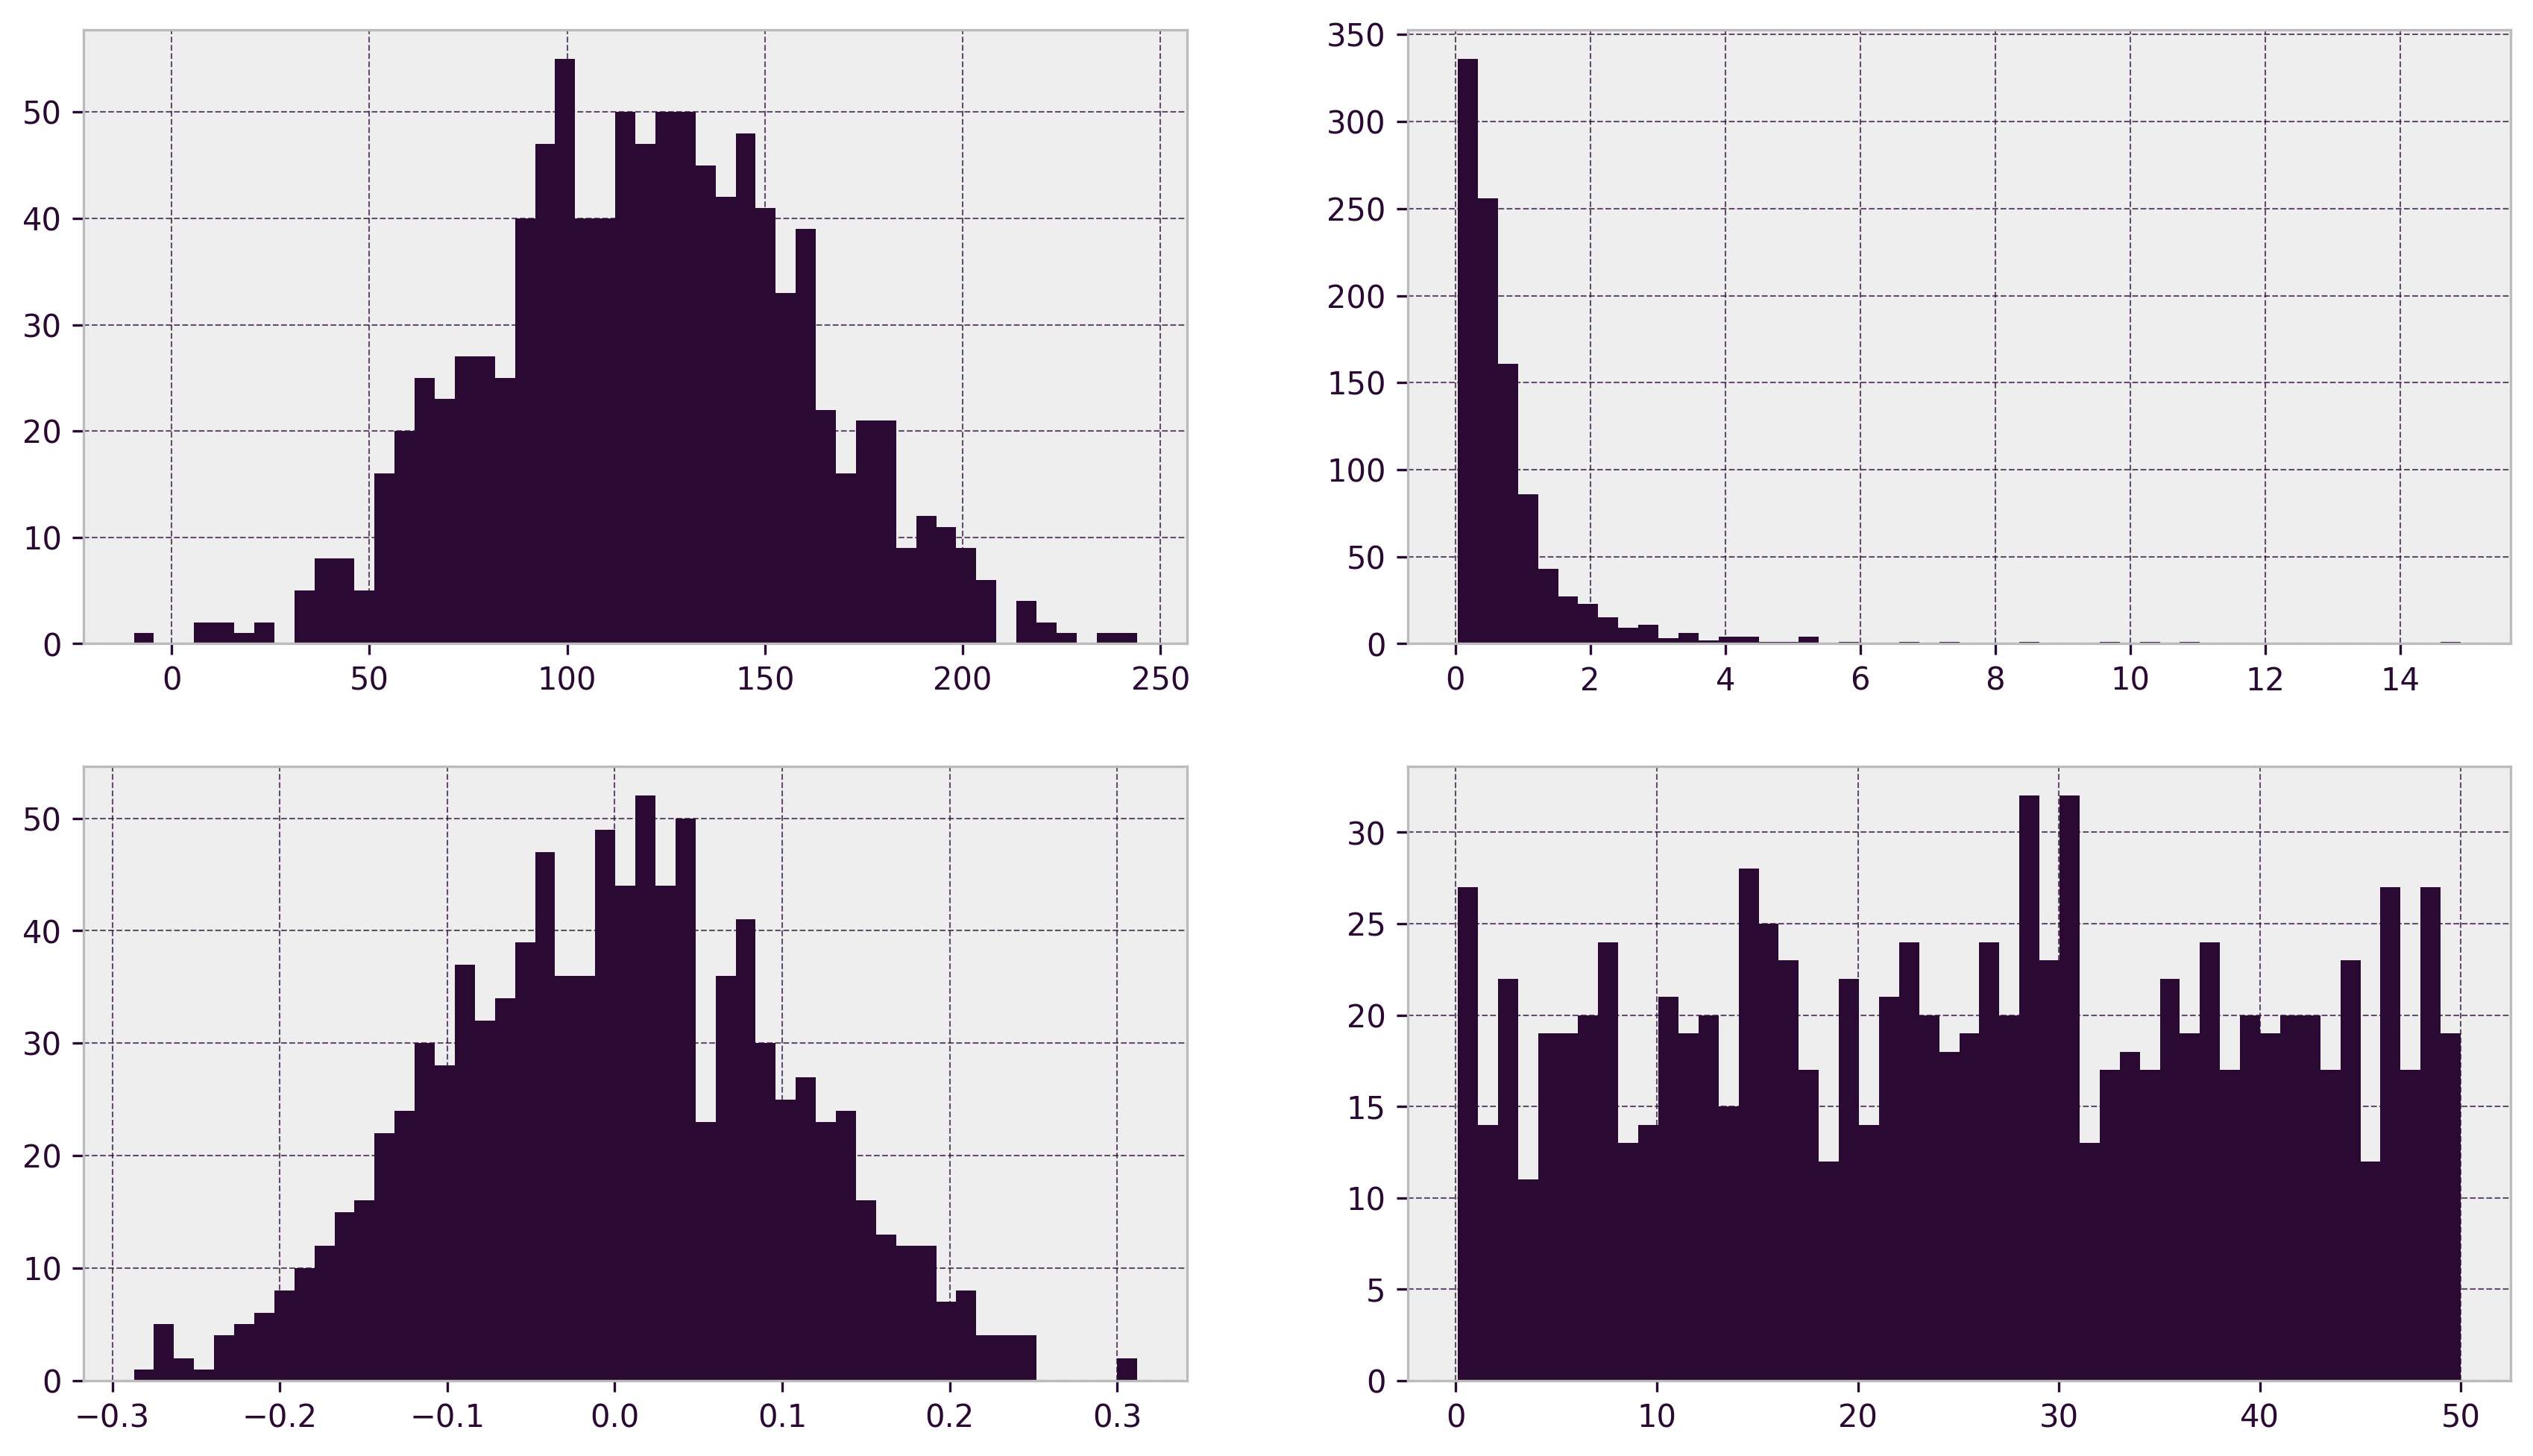

In [460]:
alpha = stats.norm.rvs(120, 40, size = 1000)
beta1 = stats.lognorm.rvs(1, 0, .5, N)
beta2 = stats.norm.rvs(0, .1, size = 1000)
sigma = stats.uniform.rvs(0, 50, size = 1000)

fig, axes = plt.subplots(figsize=(14, 8), nrows = 2, ncols = 2)
axes[0,0].hist(alpha, bins = 50, color = COLOR)
axes[0,1].hist(beta1, bins = 50, color = COLOR)
axes[1,0].hist(beta2, bins = 50, color = COLOR)
axes[1,1].hist(sigma, bins = 50, color = COLOR)
plt.show()

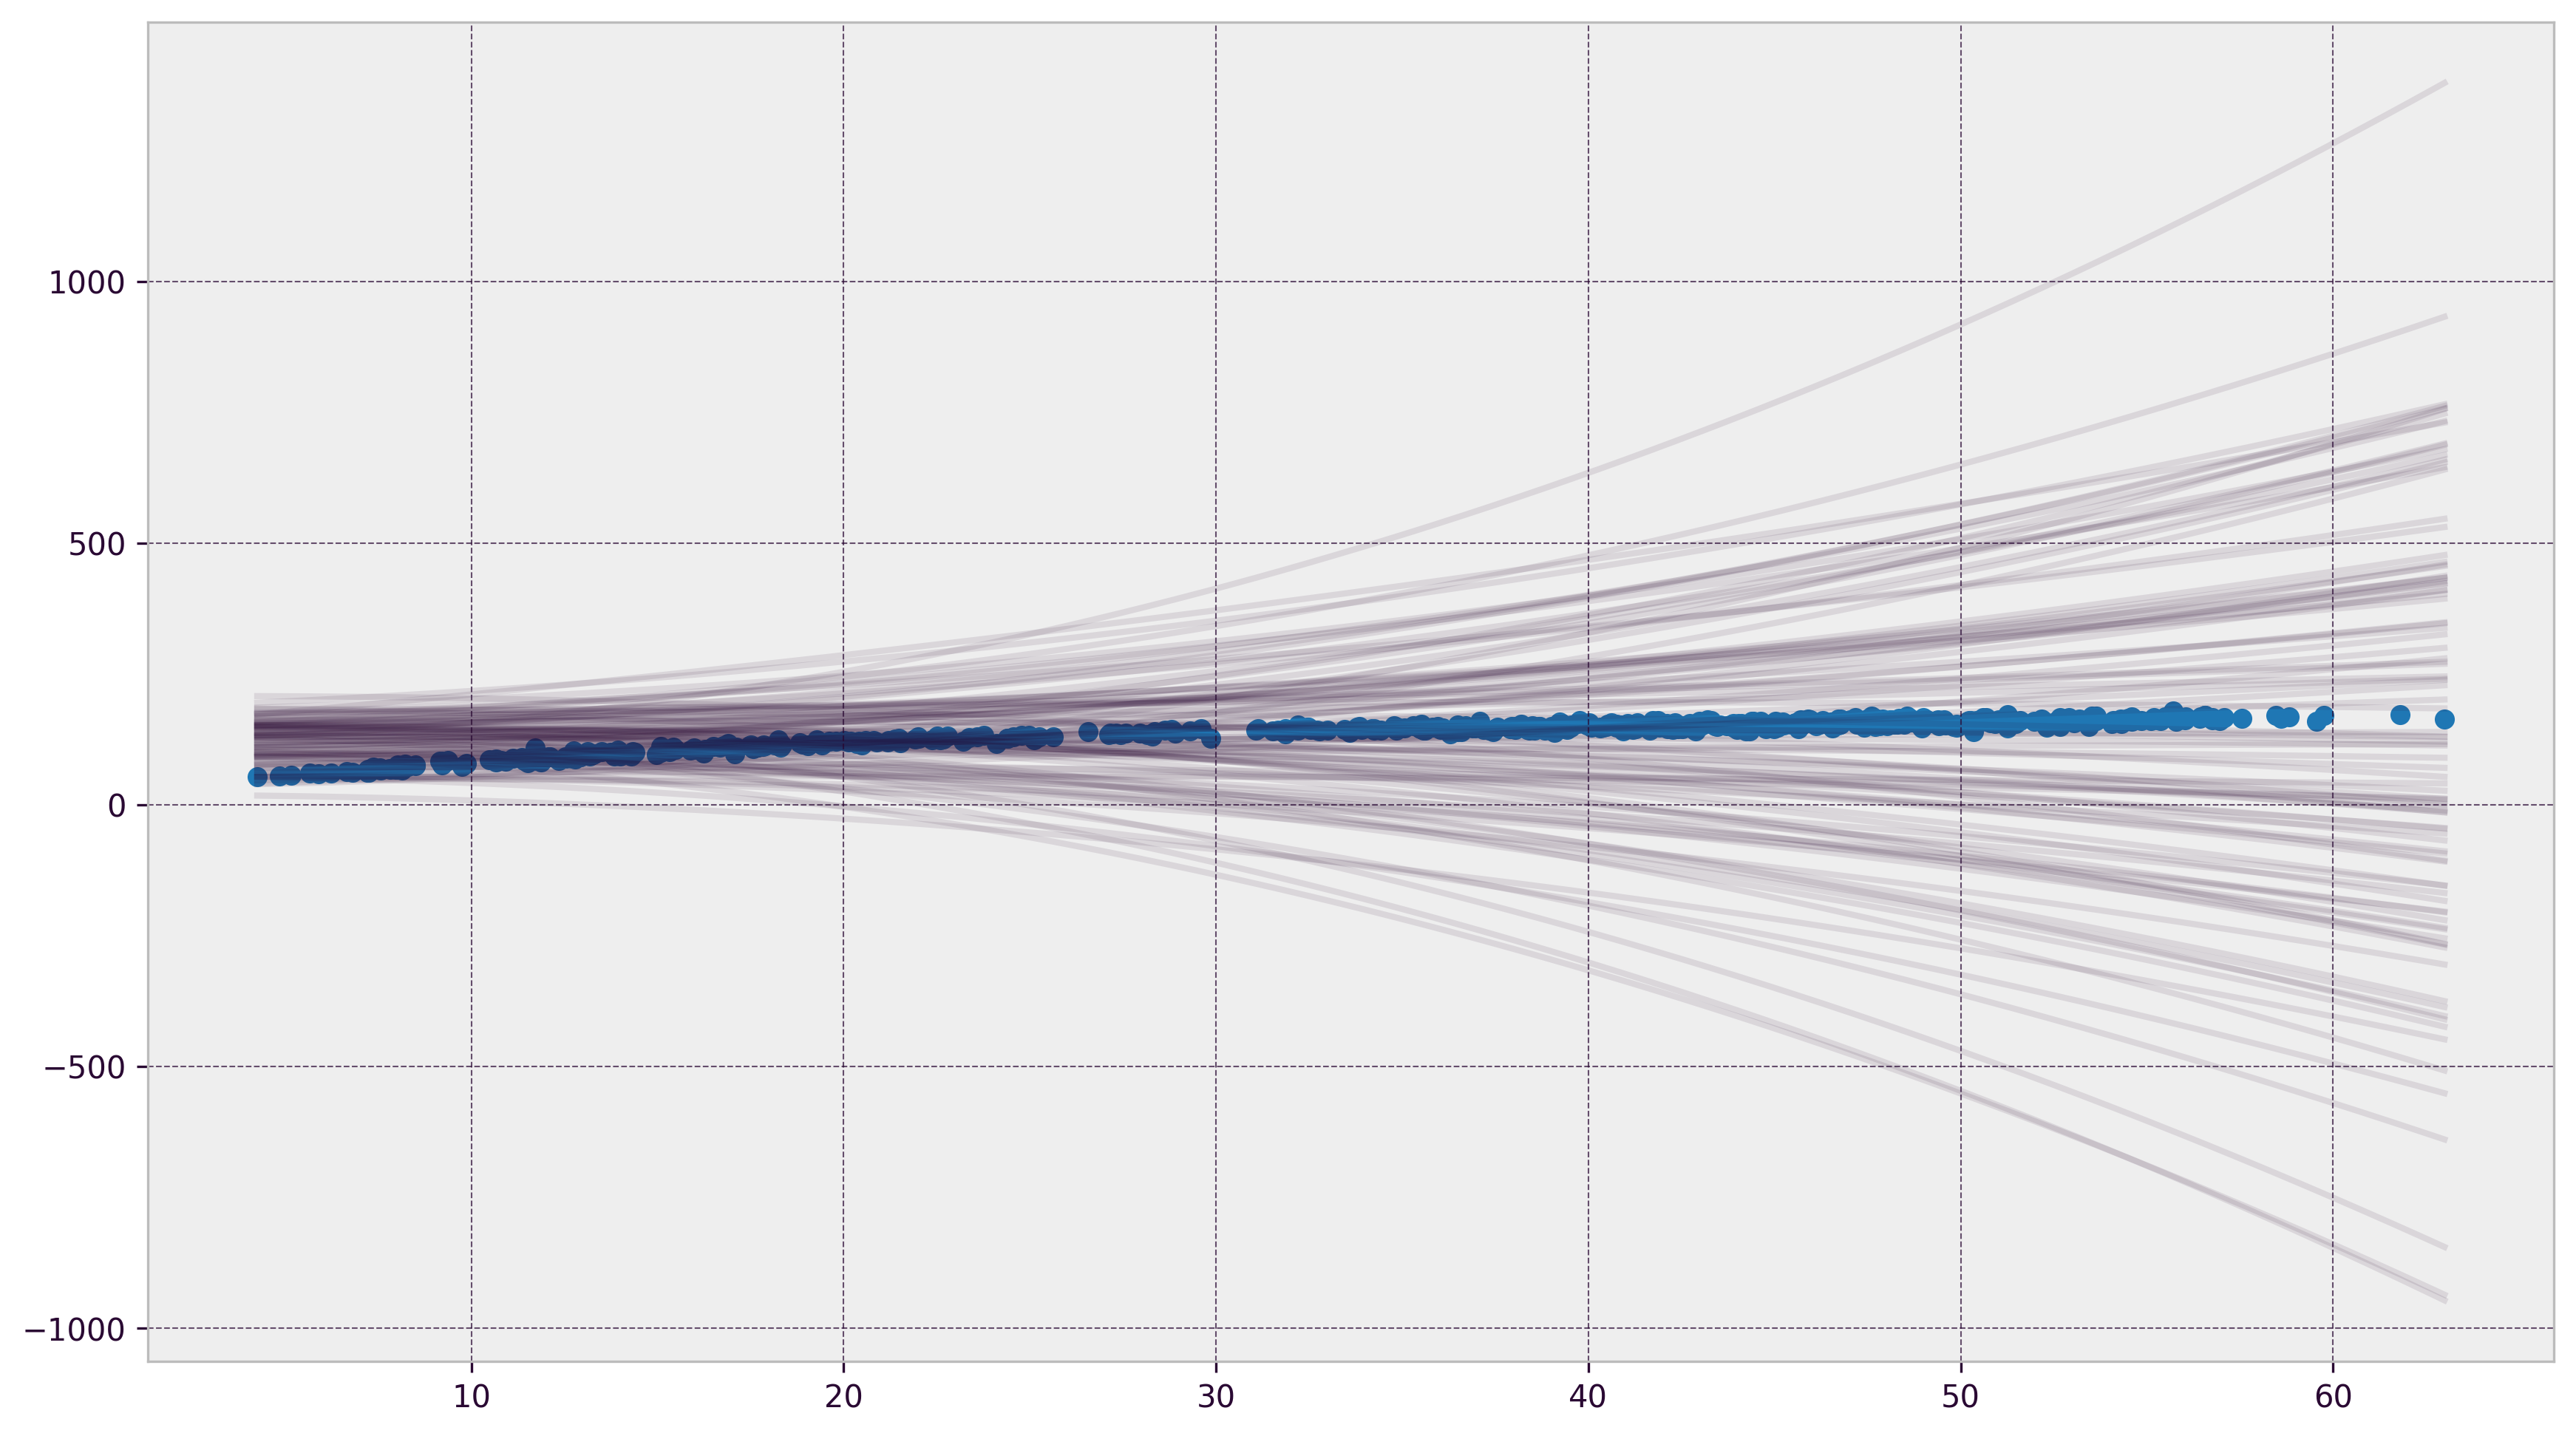

In [461]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.scatter(d['weight'], d['height'])
for i in range(100):
    y = alpha[i] + beta1[i]*xseq + beta2[i]*pow(xseq, 2)
    ax.plot(xseq, y, color = COLOR, alpha = .1)
plt.show()

# 4H5

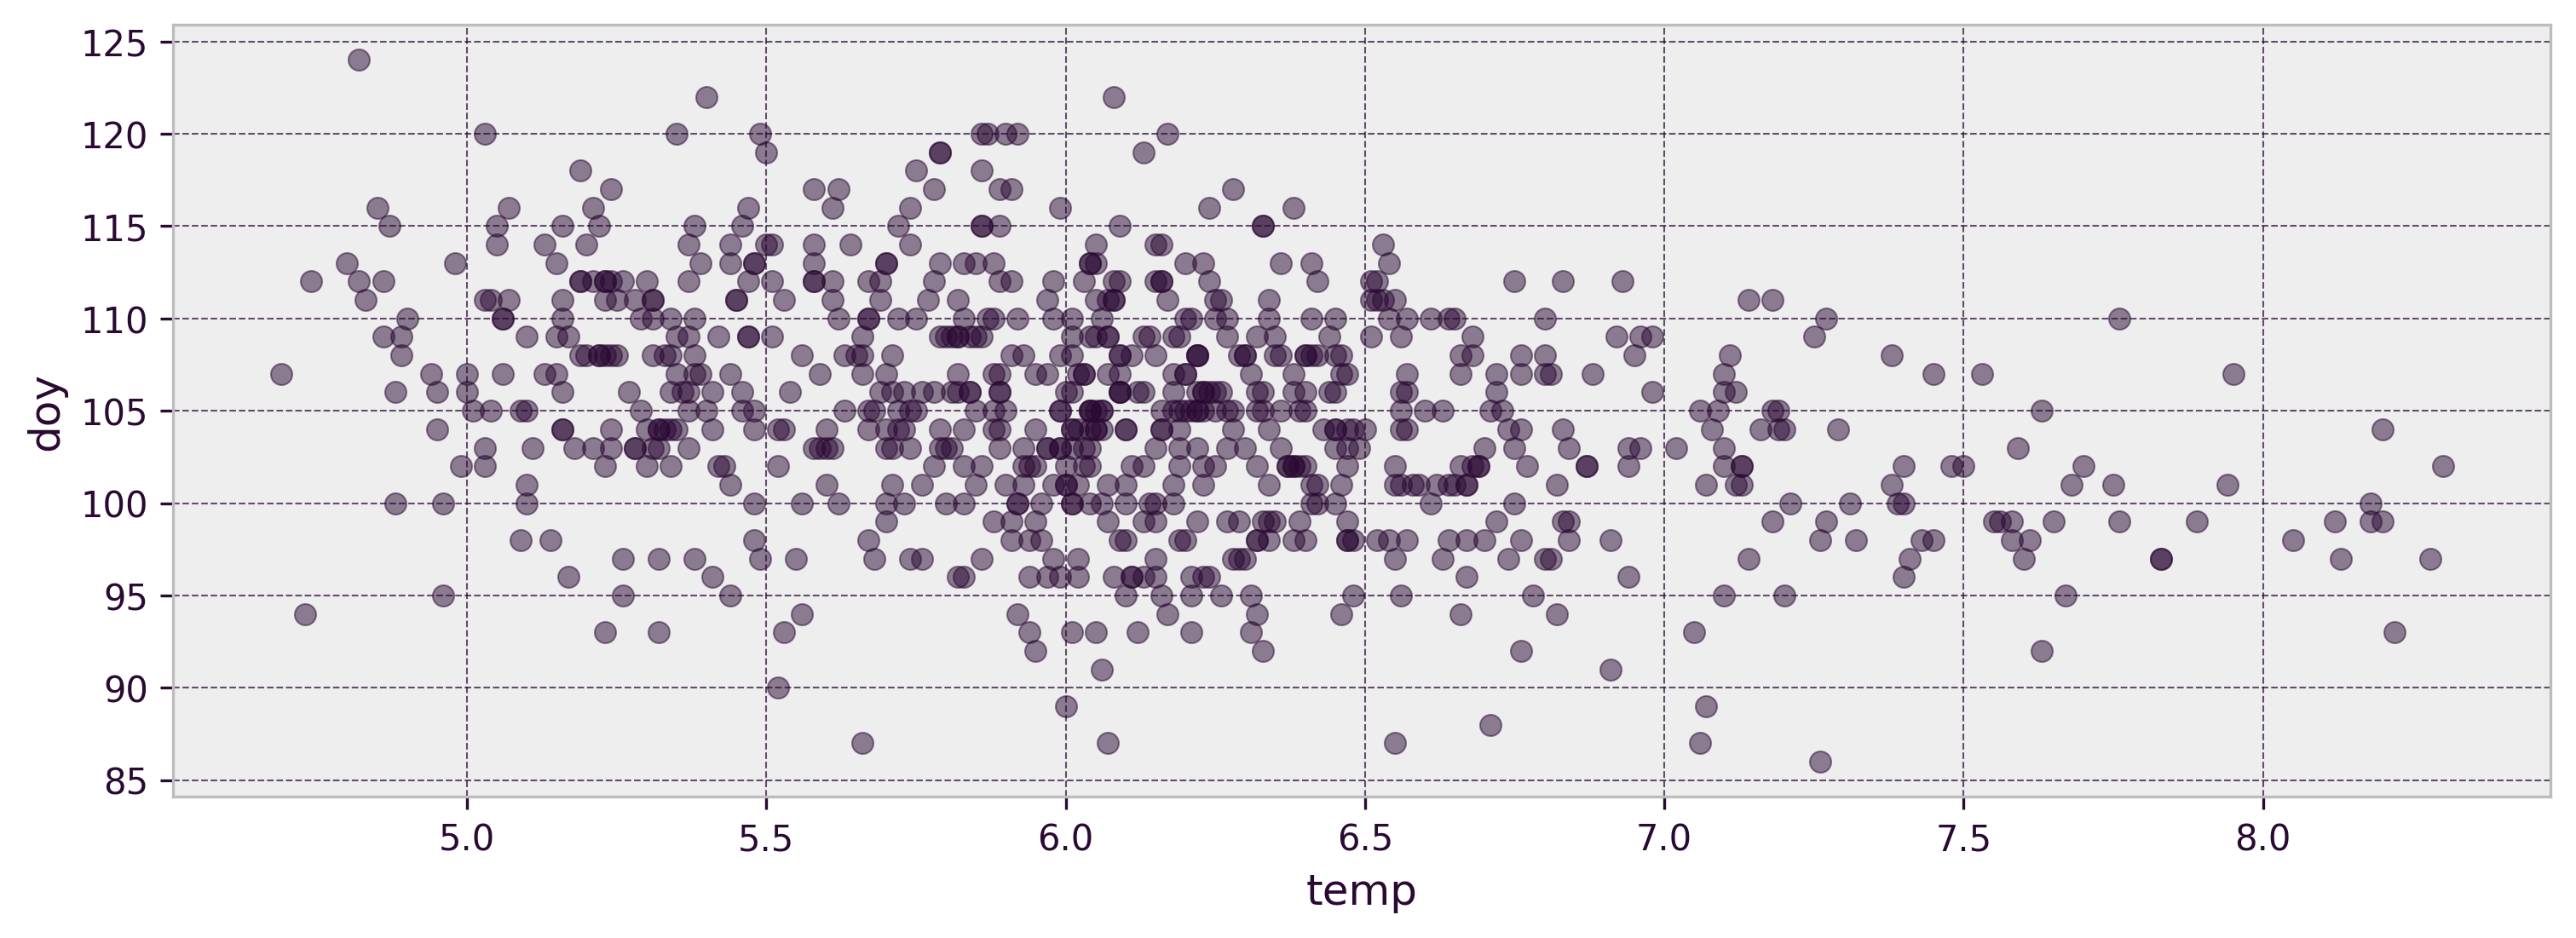

In [478]:
d = utils.data_from_R("cherry_blossoms", "rethinking")
d = d[d["doy"]>0]
d = d[["temp", "doy"]].dropna()

fig, ax = plt.subplots(figsize=(12,4))
ax.scatter(d['temp'], d['doy'], color = COLOR, alpha = .5)
ax.set_xlabel("temp")
ax.set_ylabel("doy")
plt.show()

In [483]:
from patsy import dmatrix

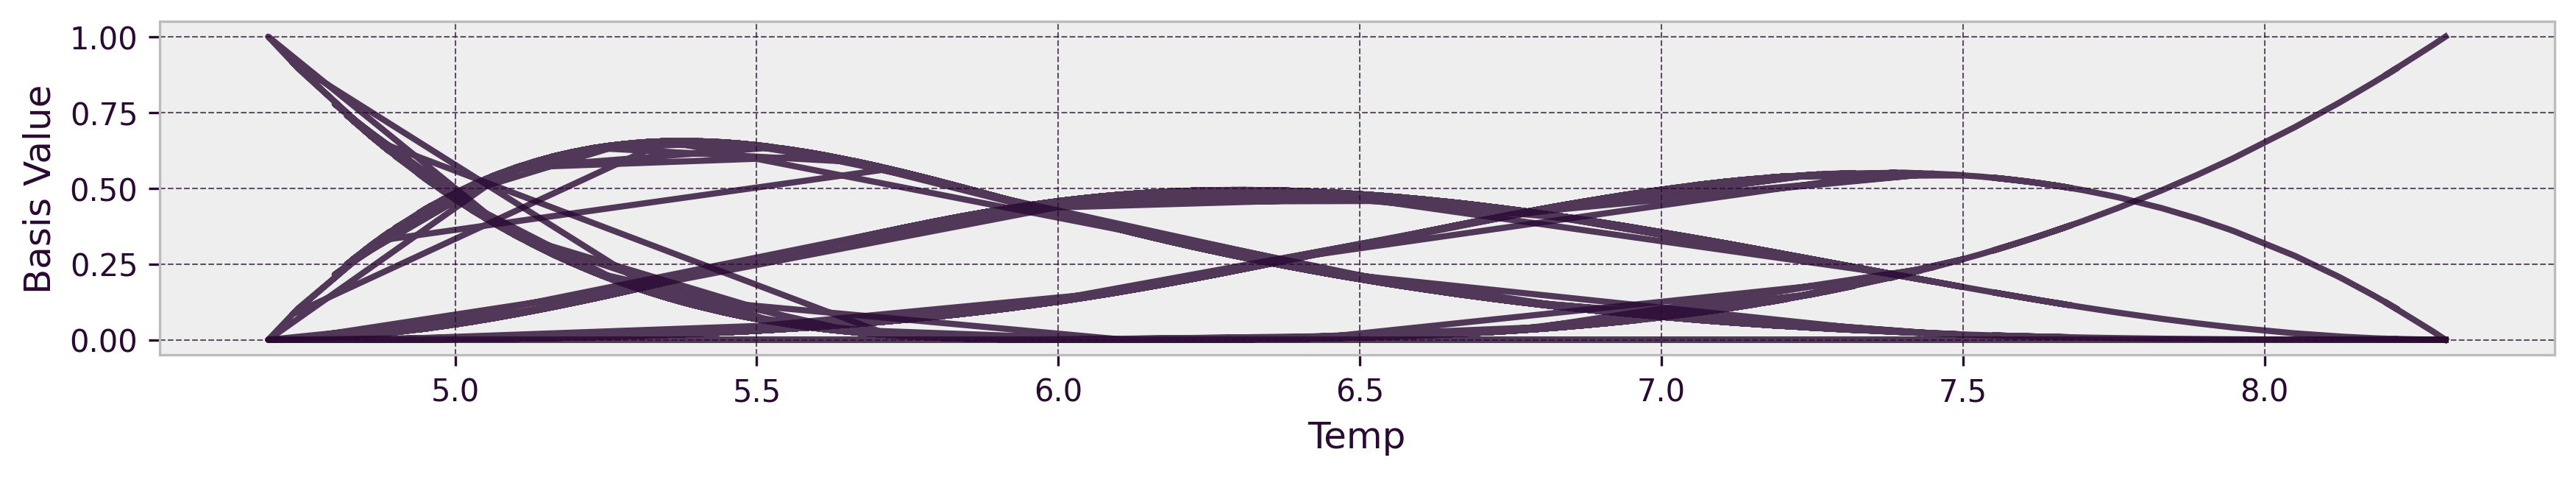

In [498]:
num_knots = 3
knot_list = np.quantile(d['temp'], np.linspace(0, 1, num_knots))
B = dmatrix(f"bs(temp, knots={tuple(knot_list[1:len(knot_list)-1])}, degree =3, include_intercept=True)",
        {"temp": d['temp']}, return_type = "matrix")

fig, ax = plt.subplots(figsize=(14,2))
for i in range(1,B.shape[1]):
    ax.plot(d['temp'], B[:,i], color = COLOR, alpha =.8)
ax.set_xlabel("Temp")
ax.set_ylabel("Basis Value")
plt.show()

In [502]:
dmatrix("bs(temp, knots=5)", {"temp":d['temp']})

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 0 dimension(s)